In [1]:
import os
import pandas as pd
import optuna
from typing import Tuple
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir('/Users/user/PycharmProjects/Shell_hachakton_2023')
from src.commons.utils import get_depot_param_space, get_refinery_param_space
from src.supply_chain_opt.greedy_algorithm import Greedy_algorithm
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/Biomass_History.csv', index_col=0)
dist = pd.read_csv('data/Distance_Matrix.csv', index_col=0)
biomass_2010 = data['2010']

# Greedy Algorithm
GA = Greedy_algorithm(biomass = biomass_2010,
                      dist = dist)

# Get space for depot optimization
space_depot, number_of_depots = get_depot_param_space(biomass=biomass_2010)
GA.number_of_depots = number_of_depots

Optimal number of depots is 18.


In [21]:
def optuna_obj(trial):

    # Generate space
    space = [trial.suggest_int('depot_idx_{}'.format(i), 0, len(GA.biomass) - 1) for i in range((GA.number_of_depots))]
    space.append(trial.suggest_float('percentage_unilized', 0.5, 1))

    # Constraints
    c1 = GA.depot_constraint(space)
    c2 = GA.harvest_constraint(space)
    # Objective
    GA.optimize = False
    cost, _, _ = GA.objective_depot(space)

    '''if (c1 > 0) and (c2 > 0): # Both constraints are violated
        depot_overutilization_penalty = GA.penalty_depot_constraint(space)
        underharvested_penalty = GA.penalty_harvest_constraint(space)
        cost = cost + depot_overutilization_penalty + underharvested_penalty
        trial.report(cost, trial.number)
        raise optuna.TrialPruned()
    elif c1 > 0: # constraint 1 is violated
        depot_overutilization_penalty = GA.penalty_depot_constraint(space)
        cost = cost + depot_overutilization_penalty
        trial.report(cost, trial.number)
        raise optuna.TrialPruned()
    elif c2 > 0: # constraint 2 is violated
        underharvested_penalty = GA.penalty_harvest_constraint(space)
        cost = cost + underharvested_penalty
        trial.report(cost, trial.number)
        raise optuna.TrialPruned()'''
    #else:
    return cost

In [22]:
study = optuna.create_study(direction='minimize')  # Create a new study.
study.optimize(optuna_obj, n_trials=50)

[I 2023-08-08 15:00:50,609] A new study created in memory with name: no-name-322c2881-2c6e-447a-b6b9-baba670e0574
[I 2023-08-08 15:00:52,718] Trial 0 finished with value: 3811101.11513717 and parameters: {'depot_idx_0': 486, 'depot_idx_1': 1811, 'depot_idx_2': 270, 'depot_idx_3': 962, 'depot_idx_4': 1142, 'depot_idx_5': 273, 'depot_idx_6': 1332, 'depot_idx_7': 1500, 'depot_idx_8': 1188, 'depot_idx_9': 1996, 'depot_idx_10': 1810, 'depot_idx_11': 1702, 'depot_idx_12': 334, 'depot_idx_13': 680, 'depot_idx_14': 576, 'depot_idx_15': 58, 'depot_idx_16': 1411, 'depot_idx_17': 2194, 'percentage_unilized': 0.5781246965488336}. Best is trial 0 with value: 3811101.11513717.
[I 2023-08-08 15:00:53,722] Trial 1 finished with value: 7015502.153347189 and parameters: {'depot_idx_0': 1472, 'depot_idx_1': 2221, 'depot_idx_2': 2342, 'depot_idx_3': 29, 'depot_idx_4': 321, 'depot_idx_5': 2391, 'depot_idx_6': 326, 'depot_idx_7': 1979, 'depot_idx_8': 1448, 'depot_idx_9': 1520, 'depot_idx_10': 2116, 'depot_i

In [23]:
optuna.visualization.plot_optimization_history(study)

In [28]:
depot_locations = list(study.best_params.values())
cost, depot_biomass_supply, solution = GA.objective_depot(depot_locations)

In [31]:
solution

,Source location,Destination location,Cost
1228,1228,1228,0.000000
49,49,49,0.000000
1996,1996,1996,0.000000
466,466,466,0.000000
342,342,342,0.000000
...,...,...,...
2149,2149,1996,5606.927284
1225,1225,1228,5612.375794
179,179,182,5634.376380
1968,1968,1907,5640.617535


In [13]:
params = list(study.best_params.values())
params

ValueError: No trials are completed yet.

In [97]:
GA.optimize = False
cost, supply, solution = GA.objective_depot(params)
cost

97956.43154805475

In [98]:
# Depot constraint is violated?
(supply > 20e3).any()

True

In [99]:
# Harvest constraint is violated?
supply.sum() < 0.8 * biomass_2010.sum()

True

In [100]:
supply

1088    21454.831038
2081    29170.891816
2327     5892.720934
1487    13269.093816
976      1220.314587
1964    20178.788451
909      2780.576506
1079     7553.911989
1883    16849.414501
997     23770.886086
1423    18507.765839
2138    13133.428096
987     24887.601288
882     39124.698687
45       4673.233675
1950     1093.241334
256     28048.585550
2023     6340.982960
dtype: float64

Text(0.5, 1.0, 'Spatial Biomass Distribution')

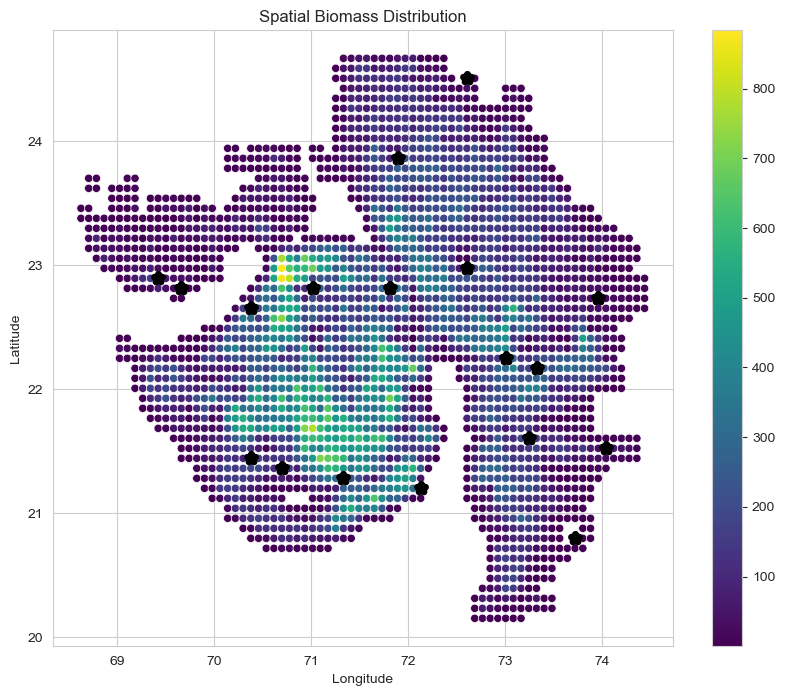

In [102]:
year = '2010'

plt.figure(figsize=(10, 8))
ax = sns.scatterplot(data=data, x='Longitude', y='Latitude', hue=year, palette='viridis')

norm = plt.Normalize(data[year].min(), data[year].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
ax.get_legend().remove()
ax.figure.colorbar(ax=ax, mappable=sm)

for loc in params[:-1]:
    y, x = data.iloc[loc, [0]].values[0], data.iloc[loc, [1]].values[0]
    ax.scatter(x, y, label=f'Depot {loc} location', marker='*', color='black', linewidth=5)
#for loc in res_refinery.x:
    #y, x = data.iloc[loc, [0]].values[0], data.iloc[loc, [1]].values[0]
    #ax.scatter(x, y, label=f'Refinery {loc} location', marker='s', color='red', linewidth=5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Biomass Distribution')